# 14-6. 프로젝트: 한국어 QA 모델 만들기

Date: 05112021

keyword
#bAbI #end-to-end memory network

data
: korean version bAbI dataset

purpose
: KOREAN QA MODEL

In [4]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import konlpy
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

from ckonlpy.tag import Twitter

In [5]:
import random 
import tensorflow as tf

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [6]:
# 환경에 맞게 경로 적절히 수정
home_dir = os.getenv('HOME')+'/aiffel/aiffel_exp_data'
DATA_DIR = home_dir + '/data'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

In [7]:
i = 0
lines = open(TRAIN_FILE , "rb")  # open: opens a file in text format by default. 
# rb:opens the file in binary format for reading 
for line in lines:
    line = line.decode("utf-8").strip()
    # lno, text = line.split(" ", 1) # ID와 TEXT 분리
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


# 데이터 전처리


In [8]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [9]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [10]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [11]:
print(len(train_stories))
print(len(train_questions))
print(len(train_answers))
print(len(test_stories))
print(len(test_questions))
print(len(test_answers))

10000
10000
10000
1000
1000
1000


In [12]:
train_stories[2400]

['필웅이는 화장실로 가버렸습니다.', '경임이는 부엌으로 갔습니다.']

In [13]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [14]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

# Tokenizer


In [15]:
from konlpy.tag import Kkma
kkma=Kkma()

In [16]:
print(kkma.morphs('이게 왜 안되는거야!!'))

['이것', '이', '왜', '안되', '는', '거', '야', '!!']


In [18]:

# 예시 코드
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('은경이', 'Noun')
twitter.morphs('은경이는 사무실로 갔습니다.')

/home/aiffel-dj54/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['은경이', '는', '사무실', '로', '갔습니다', '.']

In [19]:
def tokenize(sent):
    return twitter.morphs(sent)

In [20]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

# 형태소 분석 후 불용어 처리하기

In [21]:
#전처리 함수를 사용하여 단어장과 가장 긴 샘플의 길이를 리턴 
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [22]:
# 단어장 출력
print(word2idx)

{'는': 1, '.': 2, '로': 3, '이': 4, '했습니다': 5, '으로': 6, '경': 7, '임': 8, '은경이': 9, '수종': 10, '필웅이': 11, '이동': 12, '가버렸습니다': 13, '뛰어갔습니다': 14, '복귀': 15, '화장실': 16, '정원': 17, '복도': 18, '갔습니다': 19, '사무실': 20, '부엌': 21, '침실': 22, '어디': 23, '야': 24, '?': 25}


In [23]:
# 패딩을 고려하여 단어장 +1
vocab_size = len(word2idx) + 1

In [24]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 82
질문의 최대 길이 : 7


# Vectorize

In [25]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [26]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [27]:

print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)


(10000, 82) (10000, 7) (10000, 26) (1000, 82) (1000, 7) (1000, 26)


# 한국어에서의 모델 정확도 확인해보기

In [53]:

# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [54]:
# 입력을 담아두는 변수 정의
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 82), dtype=tf.float32, name='input_5'), name='input_5', description="created by layer 'input_5'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 7), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'")


In [55]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [56]:
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [57]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 82, 50), dtype=tf.float32, name=None), name='sequential_6/dropout_8/Identity:0', description="created by layer 'sequential_6'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 82, 7), dtype=tf.float32, name=None), name='sequential_7/dropout_9/Identity:0', description="created by layer 'sequential_7'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 7, 50), dtype=tf.float32, name=None), name='sequential_8/dropout_10/Identity:0', description="created by layer 'sequential_8'")


In [58]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 82, 7), dtype=tf.float32, name=None), name='activation_4/truediv:0', description="created by layer 'activation_4'")


In [59]:

# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 7, 82), dtype=tf.float32, name=None), name='permute_2/transpose:0', description="created by layer 'permute_2'")


In [60]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 7, 132), dtype=tf.float32, name=None), name='concatenate_2/concat:0', description="created by layer 'concatenate_2'")


In [61]:
# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
 
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/aiffel_nlp_ex/model_ko.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 3s 5ms/step - loss: 2.0718 - acc: 0.1630 - val_loss: 1.7612 - val_acc: 0.2990
Epoch 2/120
313/313 [==============================] - 1s 4ms/step - loss: 1.7175 - acc: 0.2501 - val_loss: 1.6005 - val_acc: 0.3430
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 1.6011 - acc: 0.3268 - val_loss: 1.5927 - val_acc: 0.3500
Epoch 4/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5165 - acc: 0.3804 - val_loss: 1.4716 - val_acc: 0.4300
Epoch 5/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4857 - acc: 0.4101 - val_loss: 1.4326 - val_acc: 0.4520
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4338 - acc: 0.4604 - val_loss: 1.3940 - val_acc: 0.4890
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3686 - acc: 0.4868 - val_loss: 1.3830 - val_acc: 0.4570
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

313/313 [==============================] - 1s 3ms/step - loss: 0.1689 - acc: 0.9393 - val_loss: 0.4944 - val_acc: 0.8450
Epoch 63/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1695 - acc: 0.9377 - val_loss: 0.5069 - val_acc: 0.8430
Epoch 64/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1748 - acc: 0.9415 - val_loss: 0.4945 - val_acc: 0.8490
Epoch 65/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1701 - acc: 0.9380 - val_loss: 0.4651 - val_acc: 0.8580
Epoch 66/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1627 - acc: 0.9459 - val_loss: 0.4573 - val_acc: 0.8560
Epoch 67/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1515 - acc: 0.9479 - val_loss: 0.4869 - val_acc: 0.8460
Epoch 68/120
313/313 [==============================] - 1s 3ms/step - loss: 0.1616 - acc: 0.9431 - val_loss: 0.5425 - val_acc: 0.8410
Epoch 69/120
313/313 [==============================] - 1s 3ms/step - loss:

In [62]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.4853 - acc: 0.9090

 테스트 정확도: 0.9090


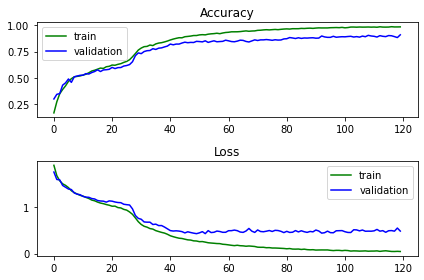

In [63]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [65]:

# NUM_DISPLAY = 30

# print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
# print(39 * "-")

# for i in range(NUM_DISPLAY):
#     question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
#     label = idx2word[ytest[i]]
#     prediction = idx2word[ytest_[i]]
#     print("{:20}: {:7} {}".format(question, label, prediction))

루브릭
평가문항	상세기준	결과
1. 한국어의 특성에 알맞게 전처리가 진행되었다.	한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.	
2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다.	validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다.	
3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다.	추론 태스크의 테스트 정확도가 90% 이상 달성하였다.	